# Проект 4. Компьютер говорит "Нет". Банковский скоринг.
## Цель проекта: Создать скоринговую модель предсказания дефолта клиентов банка.

## Необходимые библиотеки

In [1]:
from imblearn.over_sampling import SVMSMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score, precision_score, recall_score, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import f_classif, mutual_info_classif
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Внесем базовые переменные

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

# Постоянный сегодняшний день
date_today = pd.to_datetime('2020-07-21')

# Создадим дата фрейм для обработанных данных
df_tmp = pd.DataFrame()

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

## Создадим необходимые функции

In [4]:
# Построение графиков counts
def get_gr_counts(col):
    print(df[col].value_counts())
    print()
    if col != 'default':
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        fig.patch.set_facecolor('xkcd:white')
        sns.set(style="darkgrid")
        sns.countplot(x=col, data=df, ax=axes[0])
        axes[0].set_title('Общее кол-во')
        sns.countplot(x='default', hue=col, data=df, ax=axes[1])
        axes[1].set_title('Разбиение по Дефолту')
        plt.show()
    else:
        sns.set(style="darkgrid")
        sns.countplot(x=col, data=df)


# Графики для числовых параметров
def get_gr_num(col, bns=10):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style="darkgrid")

    sns.distplot(df[col], bins=bns, ax=axes[0])
    axes[0].set_title('Распределение {}'.format(col))
    sns.kdeplot(df.loc[df.default == 0, col],
                label='defualt 0', shade=True, ax=axes[1])
    sns.kdeplot(df.loc[df.default == 1, col],
                label='defualt 1', shade=True, ax=axes[1])
    axes[1].set_title('{} с делением по default'.format(col))
    sns.boxplot(x='default', y=col, data=df, ax=axes[2])
    axes[2].set_title('Boxplot {}'.format(col))


# Графики для числовых параметров df_tmp
def get_gr_num_tmp(col, bns=10):
    fig, axes = plt.subplots(1, 2, figsize=(18, 5))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style="darkgrid")

    sns.distplot(df_tmp[col], bins=bns, kde=False, ax=axes[0])
    axes[0].set_title('Распределение {}'.format(col))
    sns.boxplot(x=df['default'], y=df_tmp[col], ax=axes[1])
    axes[1].set_title('Boxplot {}'.format(col))


# Модель + метрики
def test_metrics(X, y, C=1.0, slv='lbfgs'):
    # Разобьем данные
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=RANDOM_SEED)

    # Сбалансируем Train по целевой переменной
    # sm = SVMSMOTE(random_state=RANDOM_SEED, m_neighbors=50)
    # X_train, y_train = sm.fit_resample(X_train, y_train)

    # Балансировка массивами
    # # Объединим
    # sum_arr = np.hstack((X_train, y_train[:, np.newaxis]))
    # # Посчитаем дисбаланс
    # ones = sum_arr[sum_arr[:,3] == 1]
    # zeros = sum_arr[sum_arr[:,3] == 0]
    # add_ones_count = (round(zeros.shape[0] / ones.shape[0], 0)) - 1
    # # Создадим дополнительные строки
    # add_ones = np.repeat(ones, add_ones_count, axis=0)
    # # Добавим
    # sum_arr = np.vstack((sum_arr, add_ones))
    # # Перемешаем
    # np.random.shuffle(sum_arr)
    # # Обновим
    # X_train = sum_arr[:, :-1]
    # y_train = sum_arr[:, -1]

    # Обучим модель
    clf = LogisticRegression(random_state=RANDOM_SEED,
                             max_iter=500, C=C, solver=slv)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_pred_train = clf.predict(X_train)

    # ROC AUC
    probs = clf.predict_proba(X_test)
    probs = probs[:, 1]

    fpr, tpr, threshold = roc_curve(y_test, probs)
    roc_auc = roc_auc_score(y_test, probs)

    plt.figure()
    plt.subplots(figsize=(8, 8))
    plt.plot([0, 1], label='Baseline', linestyle='--')
    plt.plot(fpr, tpr, label='Regression')
    plt.title('Logistic Regression ROC AUC = %0.6f' % roc_auc)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()


# Формирование модели для финального тестирования
def create_lr(X, y, C=1.0, slv='lbfgs'):
    clf = LogisticRegression(random_state=RANDOM_SEED,
                             max_iter=500, C=C, solver=slv)
    clf.fit(X, y)
    return clf

## Посмотрим на данные
Датасет по кредитным историям клиентов банка.

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [6]:
df_train

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0          25905  01FEB2014       SCH   M   62   Y        Y                0   
1          63161  12MAR2014       SCH   F   59   N        N                0   
2          25887  01FEB2014       SCH   M   25   Y        N                2   
3          16222  23JAN2014       SCH   F   53   N        N                0   
4         101655  18APR2014       GRD   M   48   N        N                0   
...          ...        ...       ...  ..  ...  ..      ...              ...   
73794      54887  04MAR2014       GRD   F   45   N        N                0   
73795      76821  24MAR2014       SCH   M   41   Y        Y                0   
73796     103695  22APR2014       SCH   M   31   N        N                0   
73797        861  04JAN2014       SCH   F   29   N        N                0   
73798      15796  23JAN2014       GRD   M   34   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0              0  -2.008753                1             50             1   
1              0  -1.532276                3             50             2   
2              0  -1.408142                1             80             1   
3              0  -2.057471                2             50             2   
4              1  -1.244723                1             60             2   
...          ...        ...              ...            ...           ...   
73794          0  -1.792064                3             50             1   
73795          0  -2.058029                1             50             2   
73796          0  -1.512635                4             80             2   
73797          1  -1.479334                3             50             1   
73798          0  -1.764711                2             50             2   

       work_address  income  sna  first_time foreign_passport  default  
0                 2   18000    4           1                N        0  
1                 3   19000    4           1                N        0  
2                 2   30000    1           4                Y        0  
3                 3   10000    1           3                N        0  
4                 3   30000    1           4                Y        0  
...             ...     ...  ...         ...              ...      ...  
73794             2   17000    4           4                N        0  
73795             2   70000    1           4                N        0  
73796             3   45000    2           2                N        0  
73797             3   13000    2           3                N        1  
73798             3   25000    1           3                N        0  

[73799 rows x 19 columns]

In [7]:
df_test

client_id   app_date education sex  age car car_type  decline_app_cnt  \
0          74835  22MAR2014       GRD   M   29   Y        Y                0   
1          17527  24JAN2014       SCH   F   39   N        N                5   
2          75683  23MAR2014       UGR   M   50   Y        Y                0   
3          26883  03FEB2014       SCH   M   56   N        N                0   
4          28862  04FEB2014       GRD   F   38   N        N                0   
...          ...        ...       ...  ..  ...  ..      ...              ...   
36344      83775  31MAR2014       SCH   F   37   N        N                1   
36345     106254  25APR2014       GRD   F   64   Y        Y                0   
36346      81852  30MAR2014       GRD   M   31   N        N                2   
36347       1971  07JAN2014       UGR   F   27   N        N                1   
36348      69044  17MAR2014       SCH   M   38   N        N                0   

       good_work  score_bki  bki_request_cnt  region_rating  home_address  \
0              0  -2.271884                3             50             1   
1              0  -1.504999                2             50             1   
2              0  -1.691339                1             50             1   
3              0  -2.374182                1             40             1   
4              0  -2.487502                0             80             2   
...          ...        ...              ...            ...           ...   
36344          0  -1.744976                3             50             2   
36345          0  -2.293781                3             60             1   
36346          0  -0.940752                1             50             1   
36347          0  -1.242392                2             80             2   
36348          0  -1.507549                2             50             1   

       work_address  income  sna  first_time foreign_passport  
0                 2   50000    1           4                N  
1                 2    5000    4           3                N  
2                 2   30000    1           3                Y  
3                 2   17000    1           3                N  
4                 3  120000    1           3                N  
...             ...     ...  ...         ...              ...  
36344             3   15000    4           1                N  
36345             2  200000    1           4                N  
36346             2   60000    4           2                N  
36347             3   30000    1           1                N  
36348             2   15000    4           2                N  

[36349 rows x 18 columns]

### Описание параметров
- client_id - идентификатор клиента
- education - уровень образования
- sex - пол заемщика
- age - возраст заемщика
- car - флаг наличия автомобиля
- car_type - флаг автомобиля иномарки
- decline_app_cnt - количество отказанных прошлых заявок
- good_work - флаг наличия “хорошей” работы
- bki_request_cnt - количество запросов в БКИ
- home_address - категоризатор домашнего адреса
- work_address - категоризатор рабочего адреса
- income - доход заемщика
- foreign_passport - наличие загранпаспорта
- sna - связь заемщика с клиентами банка
- first_time - давность наличия информации о заемщике
- score_bki - скоринговый балл по данным из БКИ
- region_rating - рейтинг региона
- app_date - дата подачи заявки
- default - флаг дефолта по кредиту

In [8]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1  # помечаем где у нас трейн
df_test['sample'] = 0  # помечаем где у нас тест
# в тесте у нас нет значения default, мы его должны предсказать, пока заменим на 3, чтобы отличалось от значений в df_train
df_test['default'] = 3

df = df_test.append(df_train, sort=False).reset_index(drop=True)  # объединяем
df_tmp['sample'] = df['sample']

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

### Пропуски

In [10]:
df.isnull().sum()

client_id             0
app_date              0
education           478
sex                   0
age                   0
car                   0
car_type              0
decline_app_cnt       0
good_work             0
score_bki             0
bki_request_cnt       0
region_rating         0
home_address          0
work_address          0
income                0
sna                   0
first_time            0
foreign_passport      0
sample                0
default               0
dtype: int64

**Предварительный вывод**

*В данных о клиентах присутствуют переменные всех типов, не все имеют числовую запись, а также есть пропущенные значения. Значит, нам необходима предварительная очистка данных.*
## Целевая переменная
### default - наличие дефолта
Распределение значений целевой переменной

0    64427
3    36349
1     9372
Name: default, dtype: int64



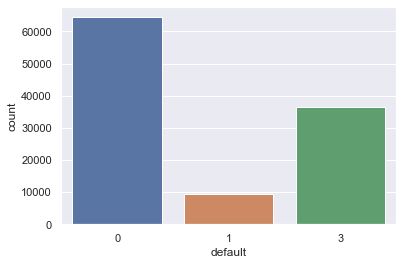

In [11]:
get_gr_counts('default')

**Предварительный вывод**

- Большинство клиентов своевременно вернули кредит и не допустили дефолта.
- Данные не сбалансированы. Нужно будет сбалансировать перед обучением модели.
- *Значение 3 - относится к тестовому дата сету. Его отделили специально, чтобы не учитывать при анализе параметров.*

### Избавимся от пропусков
Создание столбца с информацией о том, где были пропуски.

In [12]:
df_tmp['education_isNAN'] = pd.isna(df['education']).astype('uint8')

**Посмотрим на признак**

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64



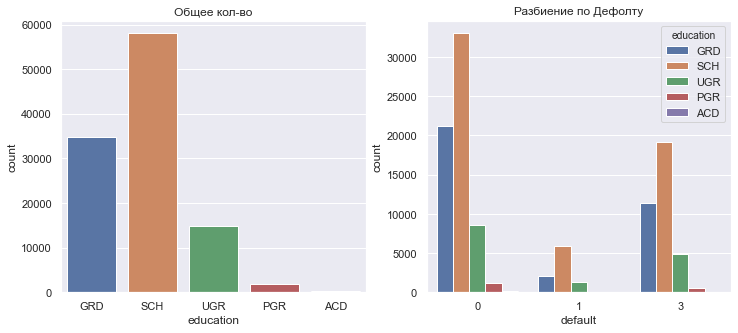

In [13]:
get_gr_counts('education')

Заполним пропуски **education** самым часто встречающимся значением - **SCH**.

In [14]:
df.education = df.education.fillna('SCH')

**Категориальный признак**

- В дата сете для обработанных данных создадим dummy-переменные.
- В рабочем дата сете заменим текстовые значения на числовые для дальнейшего анализа значимости данного параметра.

In [15]:
# Dummy-переменные в df_tmp
df_tmp['education'] = df['education']
df_tmp = pd.get_dummies(df_tmp, columns=['education'])


# Числовые перменные в df
df.education = df.education.apply(
    lambda x: 1 if x == 'ACD' else 2 if x == 'PGR' else 3 if x == 'UGR' else 4 if x == 'GRD' else 5)

### Проведем первое тестирование с имеющимися данными

In [16]:
y = df_train['default'].values

<Figure size 432x288 with 0 Axes>

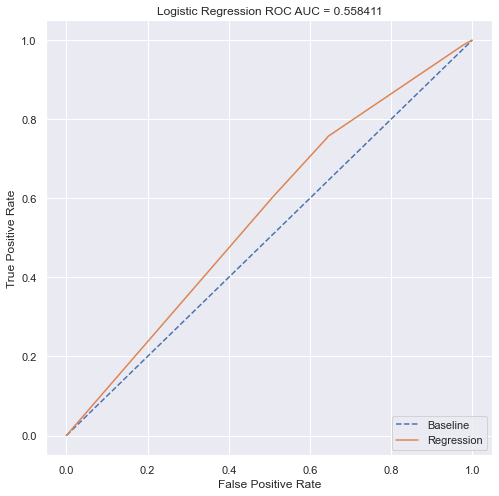

In [17]:
df_for_test = df_tmp.query('sample == 1').drop(['sample'], axis=1)
X = df_for_test.values
test_metrics(X, y)

### client_id - идентификатор клиента
Числовой параметр

In [18]:
df.client_id.value_counts()

2047     1
97541    1
93447    1
70920    1
72969    1
        ..
47810    1
45763    1
35524    1
33477    1
2049     1
Name: client_id, Length: 110148, dtype: int64

Уникальное значение - id клиента. Параметр не повторяется.

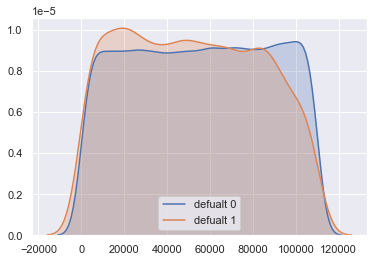

In [19]:
# Распределение вероятности дефолта в зависимости от id
sns.kdeplot(df.loc[df.default == 0, 'client_id'],
            label='defualt 0', shade=True)
sns.kdeplot(df.loc[df.default == 1, 'client_id'],
            label='defualt 1', shade=True)

**Предварительный вывод**

- Наблюдается аномальный всплеск дефолтов для id до 38 тысяч. Видимо на первых клиентах чаще ошибались.
- Картина улучшилась для id от 38 до 70 тысяч.
- После 83 тысяч ситуация поменялась на обратную.

Учтем данный нюанс созданием дополнительных признаков.

In [20]:
# Принадлежность к группам
df_tmp['id_0_38'] = df.client_id.apply(lambda x: 1 if x < 38000 else 0)
df_tmp['id_38_70'] = df.client_id.apply(
    lambda x: 1 if 38000 <= x < 70000 else 0)
df_tmp['id_70_83'] = df.client_id.apply(
    lambda x: 1 if 70000 <= x < 83000 else 0)
df_tmp['id_83_'] = df.client_id.apply(lambda x: 1 if 83000 <= x else 0)

### sex - пол заёмщика
Бинарный параметр

F    61836
M    48312
Name: sex, dtype: int64



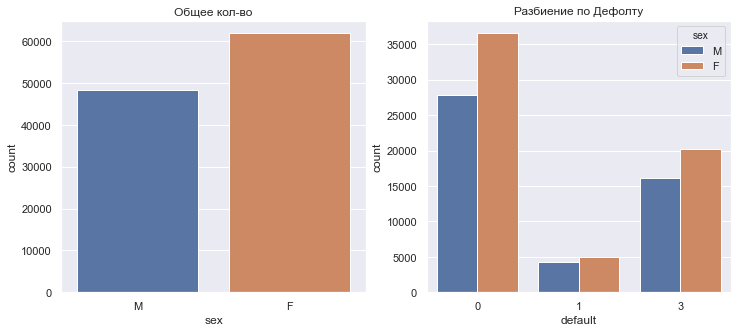

In [21]:
get_gr_counts('sex')

**Предварительный вывод**

Женщины чаще оформляют кредит и более ответственны в возврате.

In [22]:
# Преобразуем параметр в бинарный числовой формат
label_encoder = LabelEncoder()
df['sex'] = label_encoder.fit_transform(df['sex'])
df_tmp['sex'] = df['sex']

### age - возраст заёмщика
Числовой параметр

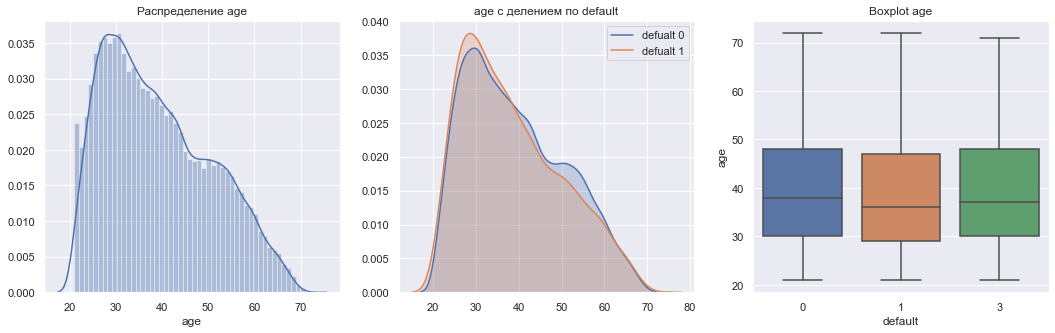

In [23]:
get_gr_num('age', 50)

**Предварительный вывод**

- Средний возраст заемщиков, допустивших дефолт ниже, чем средний возраст добросовестных клиентов (молодые люди чаще допускают дефолт по кредиту).
- С 25 до 32 лет дефолтов больше.
- С 45 до 60 лет дефолтов меньше.

Учтем этот нюанс созданием дополнительных признаков.

In [24]:
# Принадлежность к группам
df_tmp['age_25_32'] = df.age.apply(lambda x: 1 if 25 < x < 32 else 0)
df_tmp['age_45_60'] = df.age.apply(lambda x: 1 if 45 < x < 60 else 0)

### car - флаг наличия автомобиля
Бинарный параметр

N    74290
Y    35858
Name: car, dtype: int64



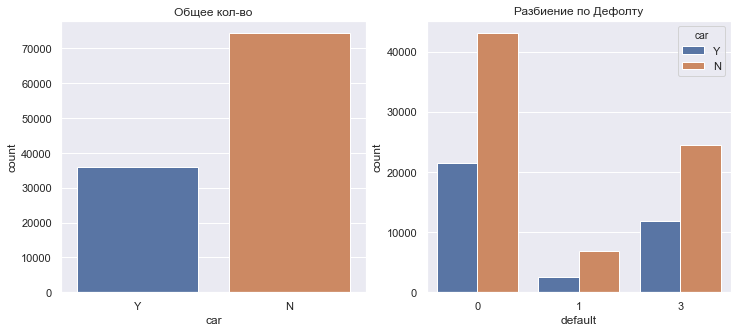

In [25]:
get_gr_counts('car')

**Предварительный вывод**

- Кредит берут больше людей, у которых отсутствует автомобиль.

In [26]:
# Преобразуем параметр в бинарный числовой формат
df['car'] = label_encoder.fit_transform(df['car'])
df_tmp['car'] = df['car']

### car_type - флаг автомобиля-иномарки
Бинарный параметр

N    89140
Y    21008
Name: car_type, dtype: int64



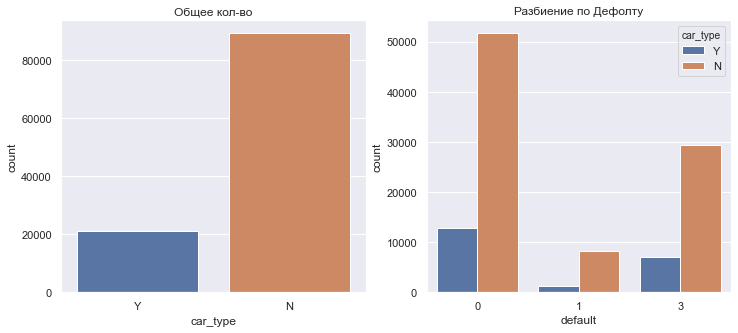

In [27]:
get_gr_counts('car_type')

**Предварительный вывод**

- Кредит берут больше людей, у которых отсутствует иномарка.

In [28]:
# Преобразуем параметр в бинарный числовой формат
df['car_type'] = label_encoder.fit_transform(df['car_type'])
df_tmp['car_type'] = df['car_type']

### decline_app_cnt - количество отказанных прошлых заявок
Числовой параметр

In [29]:
df['decline_app_cnt'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

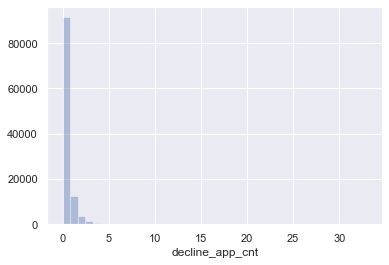

In [30]:
sns.distplot(df['decline_app_cnt'], bins=40, kde=False)

**Предварительный вывод**

- Большинству клиентов не отказывали в кредите.
- График зависимости количества клиентов от количества отказов близок к гиперболической функции.
- Будет необходимо логарифмировать и нормировать признак.

### good_work - флаг - наличия «хорошей» работы
Бинарный параметр

0    91917
1    18231
Name: good_work, dtype: int64



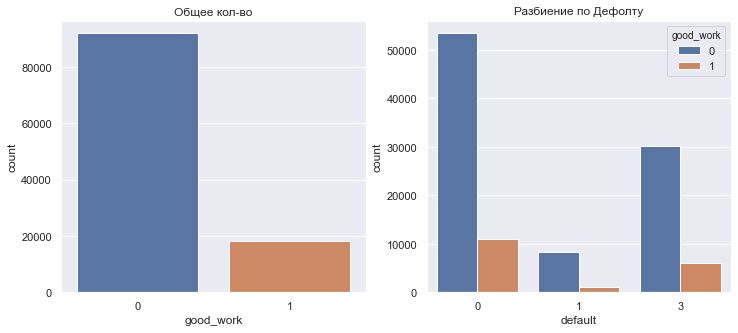

In [31]:
get_gr_counts('good_work')

**Предварительный вывод**

- Большинство людей, которые берут кредит, не имеют хорошей работы.

In [32]:
# Добавим в df_tmp
df_tmp['good_work'] = df['good_work']

### bki_request_cnt - количество запросов в БКИ
Числовой параметр

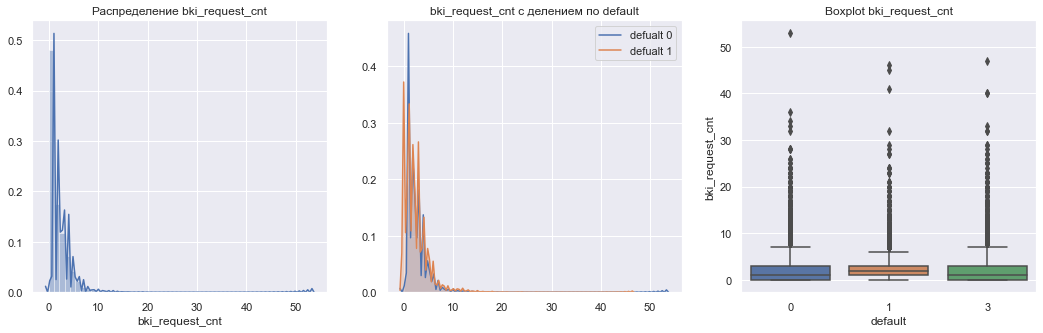

In [33]:
get_gr_num('bki_request_cnt', 50)

In [34]:
# Логарифмируем, чтобы сделать данные менее смещенными
df['bki_request_cnt'] = np.log(df['bki_request_cnt'] + 1)
df_tmp['bki_request_cnt'] = df['bki_request_cnt']

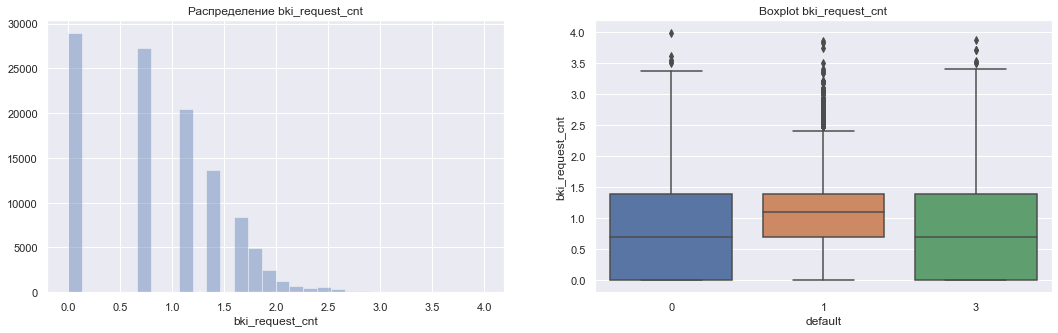

In [35]:
get_gr_num_tmp('bki_request_cnt', 30)

**Предварительный вывод**
- Количество запросов в БКИ в среднем больше у клиентов, допустивших дефолт по кредиту.
- Много выбросов, что логично с таким распределением признака.

### home_address - категоризатор домашнего адреса
Категориальный параметр

2    59591
1    48688
3     1869
Name: home_address, dtype: int64



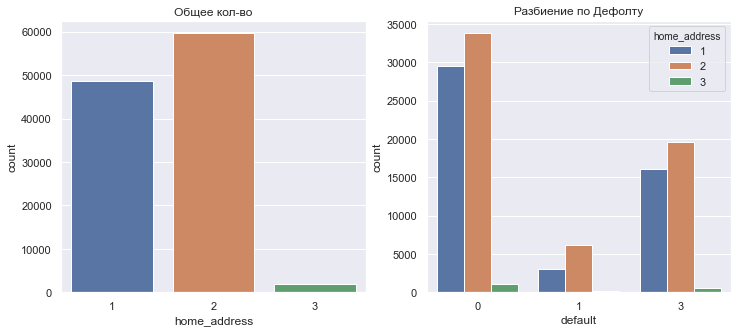

In [36]:
get_gr_counts('home_address')

**Предварительный вывод**
- Значения параметра пока не очень ясны.
- В дата сете для обработанных данных создадим dummy-переменные.

In [37]:
# Dummy-переменные в df_tmp
df_tmp['home_address'] = df['home_address']
df_tmp = pd.get_dummies(df_tmp, columns=['home_address'])

### work_address - категоризатор рабочего адреса
Категориальный параметр

3    67113
2    30761
1    12274
Name: work_address, dtype: int64



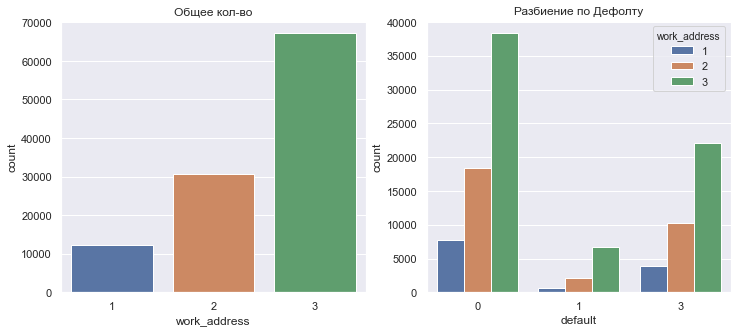

In [38]:
get_gr_counts('work_address')

**Предварительный вывод**
- Значения параметра пока также не очень ясны.
- В дата сете для обработанных данных создадим dummy-переменные.

In [39]:
# Dummy-переменные в df_tmp
df_tmp['work_address'] = df['work_address']
df_tmp = pd.get_dummies(df_tmp, columns=['work_address'])

### Предположение
Возможно, данные в **home_adress** и **work_address** относятся к району. Таким образом, если разделить одно на другое, то можно получить идентификатор удаленности работы от дома. При этом единица будет в случае совпадения районов и чем больше число будет отличаться от 1, тем большая будет разница между районами проживания и работы (тесты показали положительную эффективность данного параметра).

In [40]:
df['rel_address'] = df['work_address'] / df['home_address']

### income - доход заёмщика
Числовой параметр

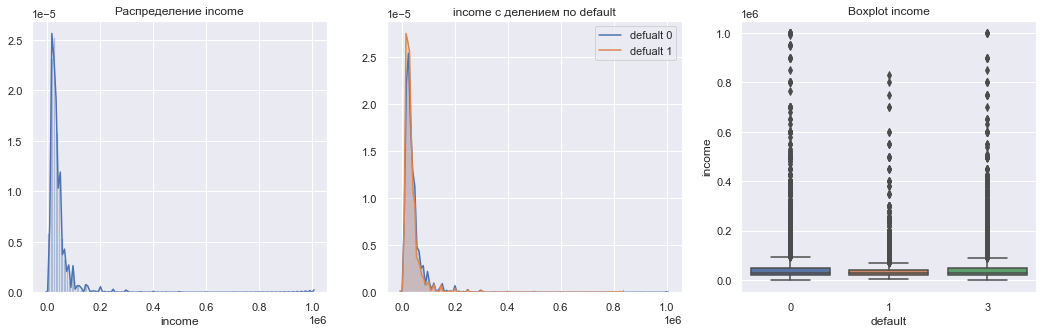

In [41]:
get_gr_num('income', 100)

In [42]:
# Логарифмируем, чтобы сделать данные менее смещенными
df['income'] = np.log(df['income'] + 1)
df_tmp['income'] = df['income']

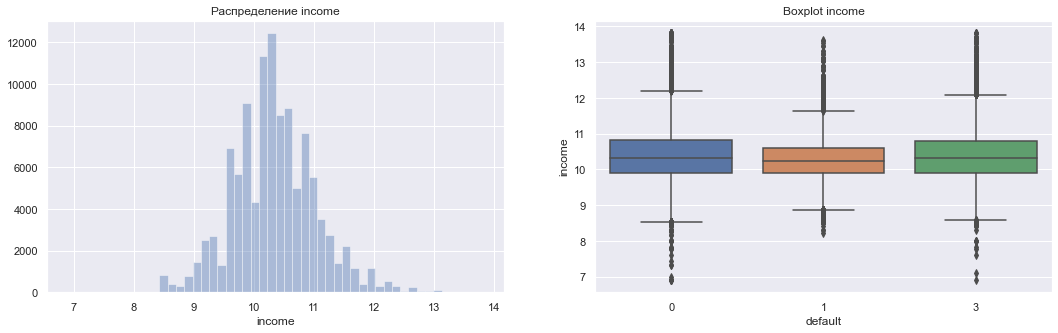

In [43]:
get_gr_num_tmp('income', 50)

**Предварительный вывод**
- Зарплата клиентов, допустивших дефолт, в среднем ниже, чем у добросовестных плательщиков по кредиту.

### foreign_passport - наличие загранпаспорта
Бинарный параметр

N    93721
Y    16427
Name: foreign_passport, dtype: int64



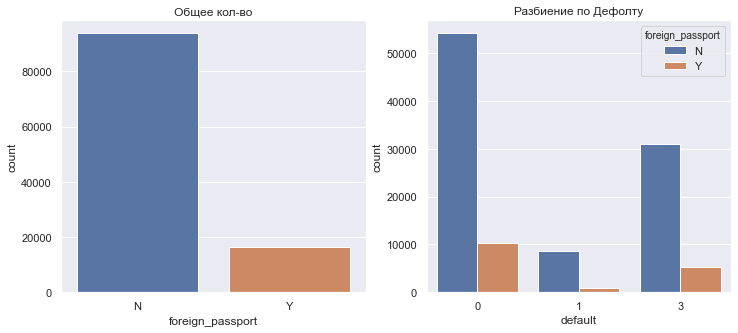

In [44]:
get_gr_counts('foreign_passport')

**Предварительный вывод**
- За кредитом обращаются больше людей, не имеющих загранпаспорт. Возможно, таких людей просто большинство в рассматриваемом обществе.

In [45]:
# Преобразуем параметр в бинарный числовой формат
df['foreign_passport'] = label_encoder.fit_transform(df['foreign_passport'])
df_tmp['foreign_passport'] = df['foreign_passport']

### score_bki - скоринговый балл по данным из БКИ
Числовой параметр

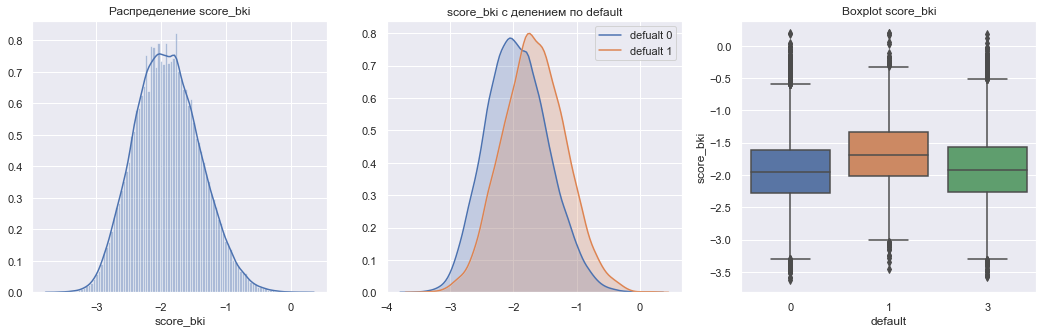

In [46]:
df_tmp['score_bki'] = df['score_bki']
get_gr_num('score_bki', 100)

**Предварительный вывод**
- Интересный параметр. Имеет нормальное распределение, логарифмировать не требуется.
- Значения в основном находятся в диапазоне от -3 до -1.
- Ближе к нулю смещены значения с положительным дефолтом. Ближе к -3 смещены значения без дефолта.
- Параметр практически подготовлен к модели, требуется только нормализация.

### region_rating - рейтинг региона
Категориальный параметр

50    40981
60    23999
40    17947
80    17170
70     9304
30      434
20      313
Name: region_rating, dtype: int64



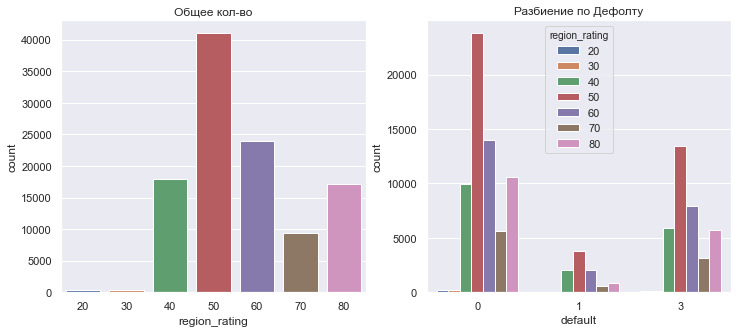

In [47]:
get_gr_counts('region_rating')

**Предварительный вывод**
- 7 вариантов значений. Большинство клиентов относятся к 50-му региону.
- В дата сете для обработанных данных создадим dummy-переменные.

In [48]:
# Dummy-переменные в df_tmp
df_tmp['region_rating'] = df['region_rating']
df_tmp = pd.get_dummies(df_tmp, columns=['region_rating'])

### sna - связь заемщика с клиентами банка
Категориальный параметр

1    70681
4    17481
2    15832
3     6154
Name: sna, dtype: int64



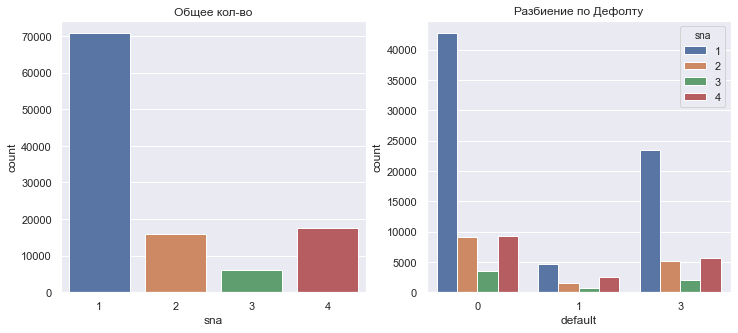

In [49]:
get_gr_counts('sna')

**Предварительный вывод**

- 4 варианта значений.
- В дата сете для обработанных данных создадим dummy-переменные.

In [50]:
# Dummy-переменные в df_tmp
df_tmp['sna'] = df['sna']
df_tmp = pd.get_dummies(df_tmp, columns=['sna'])

### app_date - дата подачи заявки
Преобразуем в формат даты, времени

In [51]:
df['app_date'] = pd.to_datetime(df['app_date'])

**Посмотрим на параметр в различных разрезах**

In [52]:
# Год
df['app_date'].dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

В дата сете данные только за 2014 год. Выделять столбец с годом не имеет смысла.

3    31597
2    27097
4    26266
1    25188
Name: month, dtype: int64



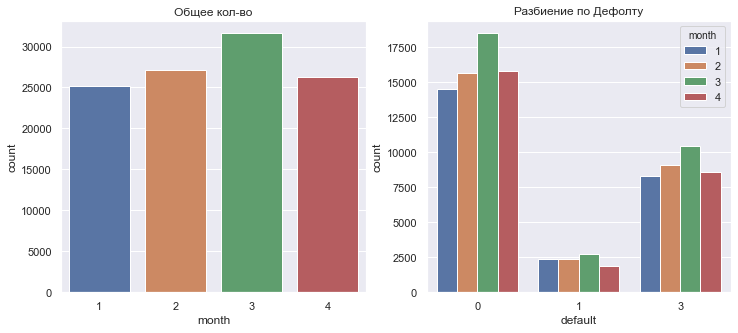

In [53]:
# Месяц
df['month'] = df['app_date'].dt.month
get_gr_counts('month')

**Предварительный вывод**
- В дата сете данные за 4 месяца.
- Пробовал создать на их основе dummy-переменные, однако они ухудшали эффективность модели на промежуточных тестах, поэтому данный параметр не используем.

1    18180
0    17858
2    17581
3    17421
4    16749
5    12202
6    10157
Name: Rev_weekday, dtype: int64



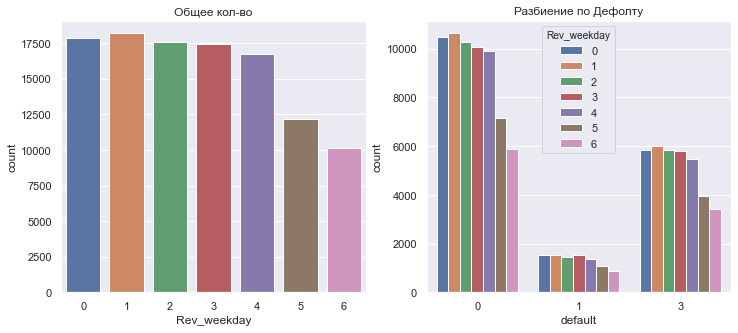

In [54]:
# День недели
df['Rev_weekday'] = df['app_date'].dt.dayofweek
get_gr_counts('Rev_weekday')

**Предварительный вывод**
- В дата сете данные за все 7 дней недели.
- Пробовал создать на их основе dummy-переменные, однако они также ухудшали эффективность модели на промежуточных тестах, поэтому данный параметр не используем.

**Сколько дней прошло с даты подачи заявки до сегодняшнего дня**

Этот показатель будет числовым и покажет очередность подачи заявок, а также распределение притока клиентов в зависимости от времени.

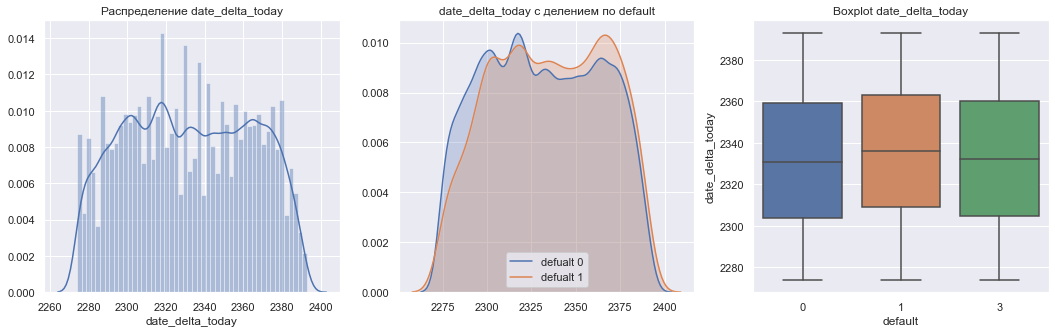

In [55]:
df['date_delta_today'] = (date_today - df['app_date']).dt.days
get_gr_num('date_delta_today', 50)

**Предварительный вывод**
- В правой части графиков расположены более ранние заявки, т. к. времени с даты их создания прошло больше.
- Графики подтверждают гипотезу, сделанную при анализе **client_id** о том, что на начальном этапе (правая часть второго графика), было привлечено больше дефолтных клиентов, а на последних этапах привлечения стали появляться более "качественные" кредиторы.
- Данные графики также показывают всплески в количестве подачи заявок по датам, видимо связанные с маркетинговой активностью банка в эти периоды времени.

### first_time - давность наличия информации о заемщике
Категориальный признак

3    46588
4    28017
1    18296
2    17247
Name: first_time, dtype: int64



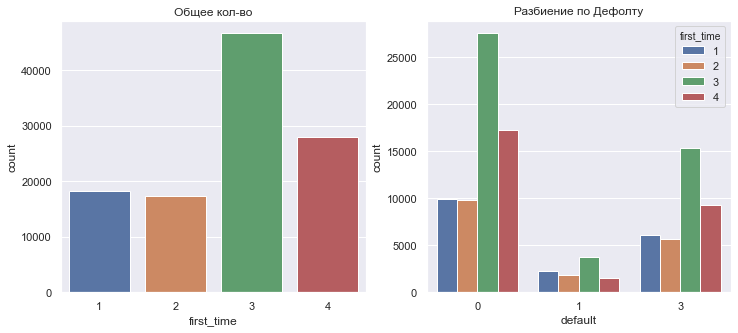

In [56]:
get_gr_counts('first_time')

**Предварительный вывод**

- 4 категории значений.
- В дата сете для обработанных данных создадим dummy-переменные.

In [57]:
# Dummy-переменные в df_tmp
df_tmp['first_time'] = df['first_time']
df_tmp = pd.get_dummies(df_tmp, columns=['first_time'])

## Распределим параметры по классам
В зависимости от типа параметра.

In [58]:
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'good_work', 'foreign_passport']

# Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address',
            'sna', 'first_time', 'region_rating']

# Числовые переменные
num_cols = ['age', 'decline_app_cnt', 'bki_request_cnt',
            'income', 'score_bki', 'date_delta_today', 'rel_address']

### Логарифмируем оставшиеся числовые признаки
Чтобы сделать данные менее смещенным. Также добавим признаки в df_tmp

In [59]:
for col in ['age', 'decline_app_cnt', 'date_delta_today', 'rel_address']:
    df[col] = np.log(df[col] + 1)
    df_tmp[col] = df[col]

## Посмотрим корреляции

In [60]:
df[num_cols].corr()

age  decline_app_cnt  bki_request_cnt    income  \
age               1.000000        -0.128624         0.050241 -0.090734   
decline_app_cnt  -0.128624         1.000000         0.127531 -0.013959   
bki_request_cnt   0.050241         0.127531         1.000000  0.078649   
income           -0.090734        -0.013959         0.078649  1.000000   
score_bki        -0.109169         0.207342         0.141600  0.002592   
date_delta_today -0.017662         0.022553         0.008669 -0.002569   
rel_address      -0.021969         0.007727        -0.005704  0.021940   

                  score_bki  date_delta_today  rel_address  
age               -0.109169         -0.017662    -0.021969  
decline_app_cnt    0.207342          0.022553     0.007727  
bki_request_cnt    0.141600          0.008669    -0.005704  
income             0.002592         -0.002569     0.021940  
score_bki          1.000000          0.062094    -0.002585  
date_delta_today   0.062094          1.000000     0.039361  
rel_address       -0.002585          0.039361     1.000000

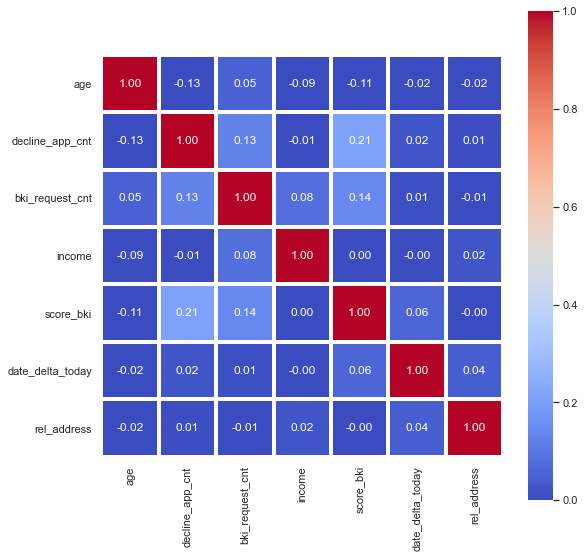

In [61]:
sns.set(font_scale=1)
plt.subplots(figsize=(9, 9))
sns.heatmap(df[num_cols].corr(), vmin=0, vmax=1, annot=True,
            fmt=".2f", linewidths=3, cmap='coolwarm', square=True)

**Предварительный вывод**
- В целом, параметры слабо скоррелированы.
- 21% корреляция между Скоринговым баллом по данным из БКИ и Количеством отказанных прошлых заявок.
- 14% корреляция между Количеством запросов в БКИ и Скоринговым баллом по данным из БКИ.
- 13% корреляция между Количеством запросов в БКИ и Количеством отказанных прошлых заявок.
- 13% обратная корреляция между Количеством отказанных прошлых заявок и Возрастом заемщиков.

## Значимость непрерывных переменных
Однофакторный дисперсионный анализ (ANOVA).

*В качестве меры значимости мы будем использовать значение f-статистики. Чем значение статистики выше, тем меньше вероятность того, что средние значения не отличаются, и тем важнее данный признак для нашей линейной модели.*

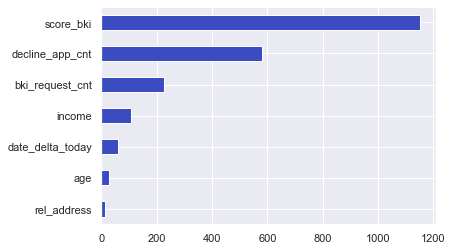

In [62]:
imp_num = pd.Series(f_classif(df[num_cols], df['default'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh', cmap='coolwarm')

**Предварительный вывод**
- Самым значимым из числовых параметром является Скоринговый балл по данным из БКИ, что подтверждает сделанный вывод при детальном анализе данного параметра.

## Значимость категориальных и бинарных признаков
Функция **mutual_info_classif**

*Опирается на непараметрические методы, основанные на оценке энтропии в группах категориальных переменных.*

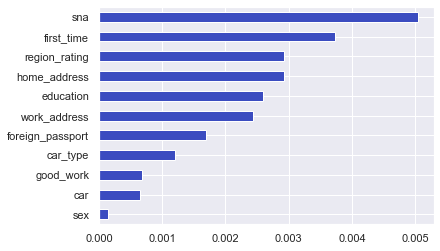

In [63]:
imp_cat = pd.Series(mutual_info_classif(
    df[bin_cols + cat_cols], df['default'], discrete_features=True), index=bin_cols + cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', cmap='coolwarm')

**Предварительный вывод**
- На основе данных о значимости признаков, после предварительного тестирования, можно создать дополнительные параметры для улучшения качества классификатора.

## Подготовка данных к машинному обучению
Перед обучением регрессии следует стандартизировать числовые признаки.

In [64]:
for col in num_cols:
    df_tmp[col] = StandardScaler().fit_transform(df_tmp[[col]].values)

In [65]:
df_tmp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 46 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   sample            110148 non-null  int64  
 1   education_isNAN   110148 non-null  uint8  
 2   education_ACD     110148 non-null  uint8  
 3   education_GRD     110148 non-null  uint8  
 4   education_PGR     110148 non-null  uint8  
 5   education_SCH     110148 non-null  uint8  
 6   education_UGR     110148 non-null  uint8  
 7   id_0_38           110148 non-null  int64  
 8   id_38_70          110148 non-null  int64  
 9   id_70_83          110148 non-null  int64  
 10  id_83_            110148 non-null  int64  
 11  sex               110148 non-null  int32  
 12  age_25_32         110148 non-null  int64  
 13  age_45_60         110148 non-null  int64  
 14  car               110148 non-null  int32  
 15  car_type          110148 non-null  int32  
 16  good_work         11

### Промежуточное тестирование

<Figure size 432x288 with 0 Axes>

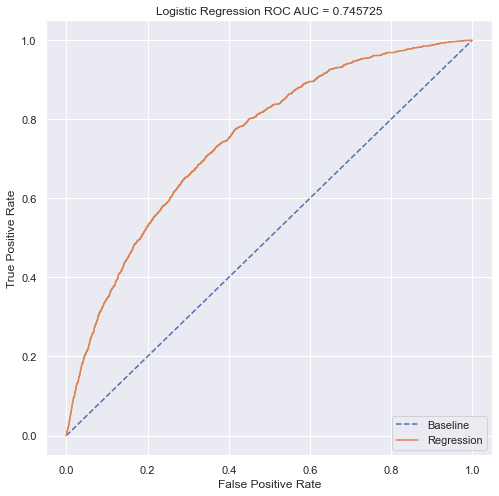

In [66]:
df_for_test = df_tmp.query('sample == 1').drop(['sample'], axis=1)
X = df_for_test.values
test_metrics(X, y)

## Корреляции всех признаков и дополнительные параметры

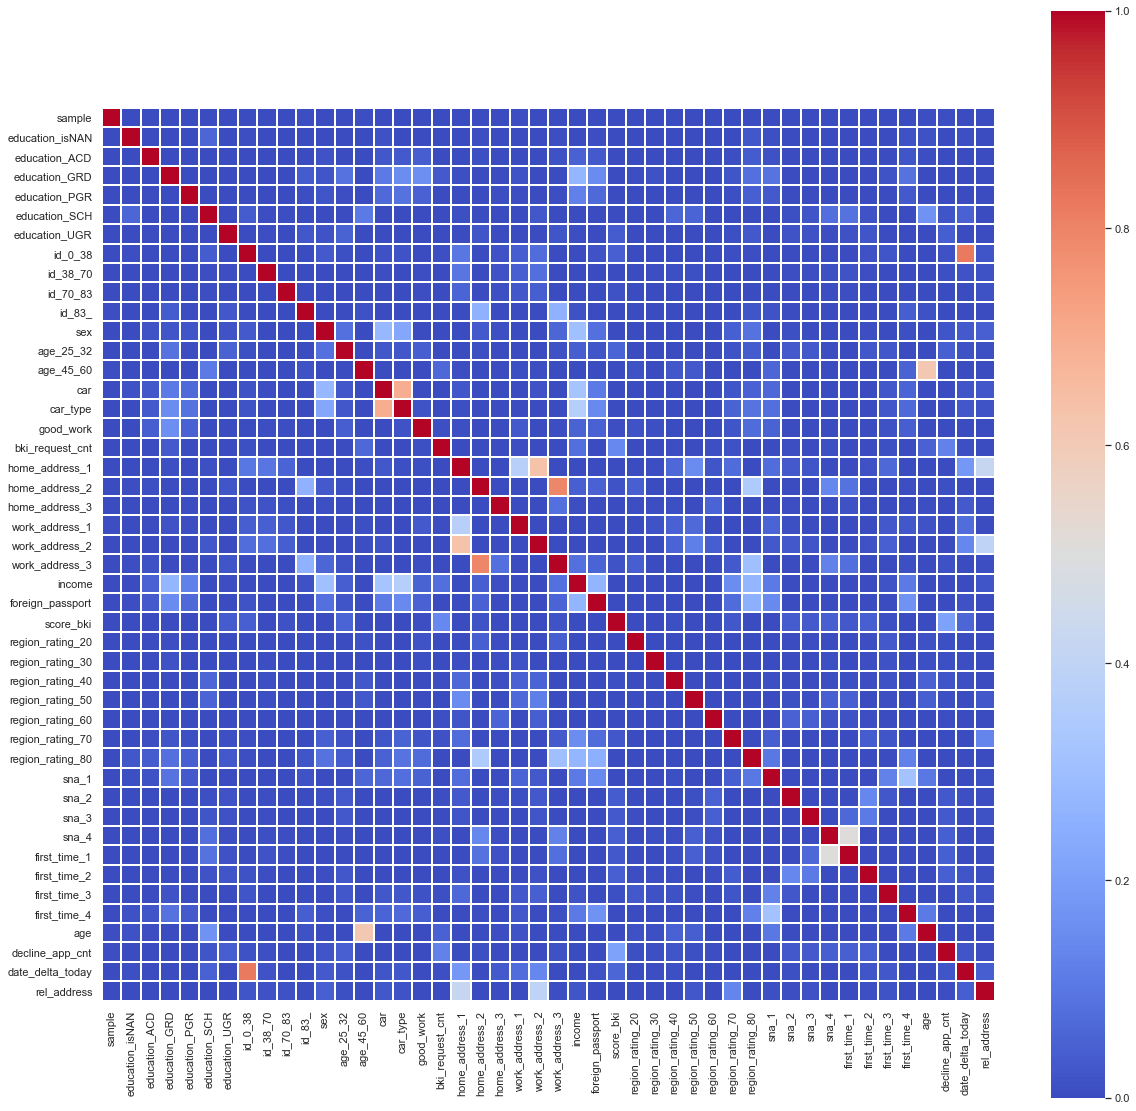

In [67]:
sns.set(font_scale=1)
plt.subplots(figsize=(20, 20))
sns.heatmap(df_tmp.corr(), vmin=0, vmax=1, fmt=".2f",
            linewidths=1, cmap='coolwarm', square=True)

**Предварительные выводы**
- Есть довольно сильно скоррелированные признаки в итоговом дата сете, однако 100% корреляции нет нигде.
- Поочередное удаление сильно скоррелированных признаков в каждом случае ухудшает качество модели, поэтому оставил все параметры.
- Все созданные дополнительные параметры, положительно влияющие на модель, в итоговом варианте ноутбука внесены в пункты по анализу параметров (выше).
- Все дополнительные параметры, которые ухудшали качество модели, в итоговый дата сет не включены.

## Регуляризация
*Поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией.*

In [68]:
# Добавим типы регуляризации
penalty = ['l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(random_state=RANDOM_SEED, max_iter=500)
model.fit(X, y)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X, y)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 2.7825594022071245


<Figure size 432x288 with 0 Axes>

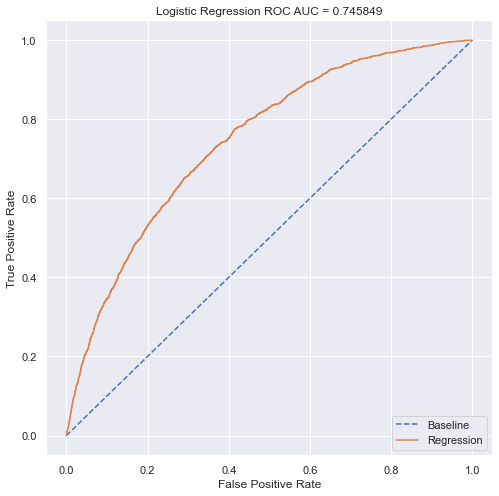

In [69]:
test_metrics(X, y, 2.7825594022071245)

**Предварительный вывод**
- Значение ROC AUC улучшилось незначительно. Попробуем подобрать параметры с большим количеством комбинаций и с ручной доводкой.

### Ручная настройка и перекрестная проверка с большим количеством параметров
- Более глубокий анализ данных дал оптимальные параметры: penalty='l2', C=1.0, solver='liblinear'
- В ноутбуке не оставил из-за долгой обработки параметров.

## Выводы
- Удалось создать классификатор логистической регрессии и повысить качество его предсказательной способности. Показатель ROC AUC вырос с 0,558 до 0,746.
- Проведена работа по анализу и обогащению входных данных. Выводы по признакам приведены после обработки каждого параметра.
- Логарифмирование и нормализация числовых параметров существенно повышает предсказательную способность модели.
- Проведена большая работа по созданию и тестированию новых параметров. Большая часть данной работы не вошла в итоговый ноутбук из-за низкой эффективности большого количества новых параметров. Вывод по данному пункту – то, что хорошо работало для деревьев, не сработало для логистической регрессии из-за специфики алгоритма.
- Применен метод однофакторного дисперсионного анализ (ANOVA) для оценки влияния непрерывных параметров на целевую переменную.
- Применена функция mutual info classif для оценки влияния категориальных и бинарных параметров на целевую переменную.
- Для преобразования бинарных переменных применялся label encoder.
- Для поиска гиперпараметров применялась GridSearchCV - перебор параметров по сетке с последующей кросс-валидацией. Также гиперпараметры подбирались вручную до достижения оптимальной настройки модели.
- Для борьбы с дисбалансом дата сета по целевой переменной использовались три метода: насыщение тренировочной выборки дублями строк с недостающим значением целевой переменной с помощью массивов numpy, а также методами генерации строк SMOTE и SVMSMOTE. Ни один из методов не дал прироста эффективности модели, а методы SMOTE и SVMSMOTE еще и замедлили процесс обработки данных, поэтому они деактивированы в коде ноутбука.
- Получен максимальный результат для имеющихся на данный момент знаний.
- В целом, проект интересный и познавательный. Благодарю авторов проекта за полезный кейс и проделанную работу по его подготовке!
